# PyTorch Image Classifier
- Reference: https://colab.research.google.com/github/bentoml/gallery/blob/master/pytorch/cifar10-image-classification/pytorch-cifar10-image-classification.ipynb
- 조교: 이정수 (bebeto@kaist.ac.kr)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
!pip install -q bentoml "torch==1.6.0" "torchvision==0.7.0" "pillow==7.2.0"


     |████████████████████████████████| 4.0 MB 8.9 MB/s 
     |████████████████████████████████| 748.8 MB 18 kB/s 
     |████████████████████████████████| 5.9 MB 45.2 MB/s 
     |████████████████████████████████| 2.2 MB 53.1 MB/s 
     |████████████████████████████████| 1.1 MB 55.5 MB/s 
     |████████████████████████████████| 146 kB 63.0 MB/s 
     |████████████████████████████████| 86 kB 7.7 MB/s 
     |████████████████████████████████| 63 kB 3.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 131 kB 69.6 MB/s 
     |████████████████████████████████| 79 kB 10.3 MB/s 
     |████████████████████████████████| 1.3 MB 68.4 MB/s 
     |████████████████████████████████| 109 kB 67.7 MB/s 
     |████████████████████████████████| 131 kB 76.9 MB/s 
     |████████████████████████████████| 209 kB 80.6 MB/s 
     |████████████████████████████████| 160 kB 72.2 MB/s 
     |████

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms

# Training an image classifier

We will do the following steps in order:

* Load and normalizing the CIFAR10 training and test datasets using torchvision
* Define a Convolutional Neural Network
* Define a loss function
* Train the network on the training data
* Test the network on the test data
* Model Serving with BentoML


## 1 Loading and Normalizing CIFAR10

The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1].

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) #MINIST와 다르게 채널이 3개이기 때문에

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

0it [00:00, ?it/s]

Failed download. Trying https -> http instead. Downloading http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to ./data/cifar-10-python.tar.gz


0it [00:00, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Let us show some of the training images, for fun.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


img scale min: -0.9607843160629272 max: 1.0


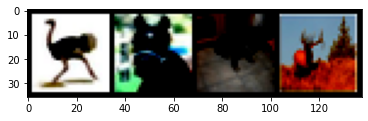

img scale min: 0.019607841968536377 max: 1.0


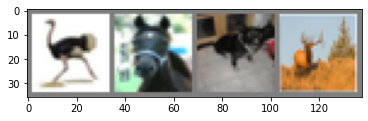

 bird horse   dog  deer


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

# scale에 따른 시각화차이를 보여주기 위함
def imshow(img):
    print(f'img scale min: {img.min()} max: {img.max()}')
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

    plt.close()

    img = img / 2 + 0.5     # unnormalize 
    print(f'img scale min: {img.min()} max: {img.max()}')
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## 2 Define a Convolutional Neural Network

Copy the neural network from the Neural Networks section before and modify it to take 3-channel images (instead of 1-channel images as it was defined).

In [6]:
import torch.nn as nn
import torch.nn.functional as F

# LeNet

In [7]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10) #TODO1: number of classes만큼 prediction 하기 

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # TODO2: 텐서를 flatten 시키기 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# ResNet

In [8]:
net = LeNet()

In [9]:
#net = net.cuda()

## 3 Define a Loss function and optimize

Let’s use a Classification Cross-Entropy loss and SGD with momentum.

In [10]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## 4 Train the network

This is when things start to get interesting. We simply have to loop over our data iterator, and feed the inputs to the network and optimize.

In [15]:
for epoch in range(1):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        # TODO3: input을 model에 forwarding 하기
        outputs = net(inputs) 
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.432
[1,  4000] loss: 1.399
[1,  6000] loss: 1.367
[1,  8000] loss: 1.339
[1, 10000] loss: 1.306
[1, 12000] loss: 1.282
Finished Training


## 5 Test the network on the test data

We have trained the network for 2 passes over the training dataset. But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network outputs, and checking it against the ground-truth. If the prediction is correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


img scale min: -1.0 max: 1.0


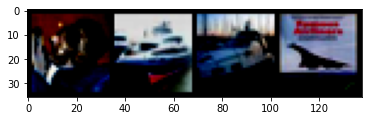

img scale min: 0.0 max: 1.0


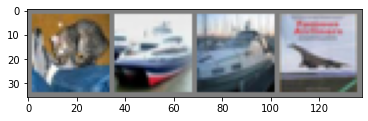

GroundTruth:    cat  ship  ship plane


In [16]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Test accuracy 50% 이상 달성


In [17]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        # TODO 4: prediction 값을 기준으로 max 값으로 predicted label 만들기 
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 53 %
